# Fake News Detection

In [ ]:
# import the tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import plot_roc_curve, classification_report, plot_confusion_matrix, log_loss
from lightgbm import LGBMClassifier
from gensim.models import Word2Vec
!pip install pyLDAvis
import pyLDAvis.gensim
import spacy
!pip install optuna
import optuna
import warnings
warnings.filterwarnings("ignore")

In [2]:
import nltk
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
# Import data
data = pd.read_csv("drive/My Drive/ML Project/news/news.csv")
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
data

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [5]:
data.columns

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

In [6]:
data.drop("Unnamed: 0", axis=1, inplace=True)

## Preprocessing

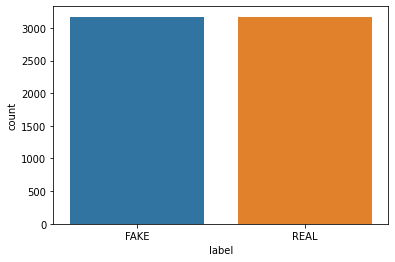

In [7]:
# Check if the data is balanced or not
sns.countplot(data["label"]);

In [8]:
# Check for missing values
data.isna().sum()

title    0
text     0
label    0
dtype: int64

### Remove Punctuation and numbers from the data

In [9]:
def clean_punc(text):
  cleaned_text = re.sub(r'[^\w\s]', '', text)
  cleaned_text = re.sub(r'[0-9]', r'', cleaned_text)
  return cleaned_text

In [10]:
data["cleaned_text"] = np.vectorize(clean_punc)(data["text"])
data.head()

,title,text,label,cleaned_text
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,Daniel Greenfield a Shillman Journalism Fellow...
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Google Pinterest Digg Linkedin Reddit Stumbleu...
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,US Secretary of State John F Kerry said Monday...
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,Kaydee King KaydeeKing November The lesson ...
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,Its primary day in New York and frontrunners H...


### Remove Stopwords

In [11]:
stop = set(stopwords.words("english"))
data["cleaned_text"] = data["cleaned_text"].apply(lambda x : " ".join([w for w in x.split() if w not in stop and len(w) > 3]))

### Tokenize the tweet

In [12]:
texts = data["cleaned_text"].apply(lambda x: x.split())
texts.head()

0    [Daniel, Greenfield, Shillman, Journalism, Fel...
1    [Google, Pinterest, Digg, Linkedin, Reddit, St...
2    [Secretary, State, John, Kerry, said, Monday, ...
3    [Kaydee, King, KaydeeKing, November, lesson, t...
4    [primary, York, frontrunners, Hillary, Clinton...
Name: cleaned_text, dtype: object

### Lemmatizing the texts

In [13]:
lemma = WordNetLemmatizer()
lemming_texts = texts.apply(lambda x:[lemma.lemmatize(i) for i in x])
lemming_texts

0       [Daniel, Greenfield, Shillman, Journalism, Fel...
1       [Google, Pinterest, Digg, Linkedin, Reddit, St...
2       [Secretary, State, John, Kerry, said, Monday, ...
3       [Kaydee, King, KaydeeKing, November, lesson, t...
4       [primary, York, frontrunners, Hillary, Clinton...
                              ...                        
6330    [State, Department, told, Republican, National...
6331    [Should, Stand, Plutocratic, Pentagon, Posted,...
6332    [AntiTrump, Protesters, Tools, Oligarchy, Refo...
6333    [ADDIS, ABABA, Ethiopia, President, Obama, con...
6334    [Bush, Suddenly, Attacking, Trump, Heres, That...
Name: cleaned_text, Length: 6335, dtype: object

In [14]:
for i in range(len(lemming_texts)):
  lemming_texts[i] = " ".join(lemming_texts[i])

data["cleaned_text"] = lemming_texts

## WordCloud for the texts

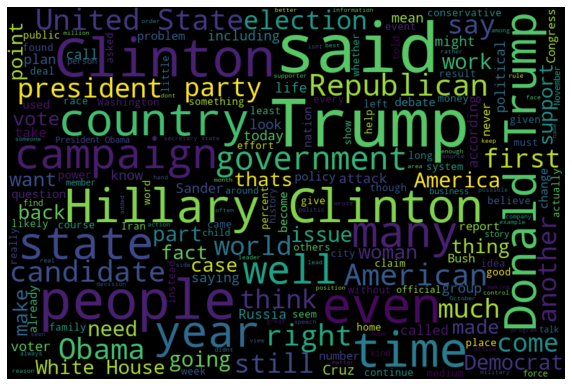

In [15]:
# Generate wordcloud for the cleaned texts
words = " ".join([text for text in data["cleaned_text"]])
wordclouds = WordCloud(width=900, height=600, random_state=42, max_font_size=110).generate(words)

plt.figure(figsize=(10, 10))
plt.imshow(wordclouds, interpolation="bilinear")
plt.axis("off")
plt.show()

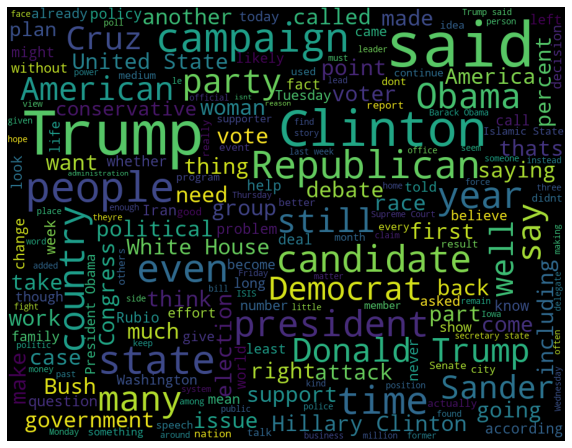

In [16]:
# Wordcloud for positive words
positive_words = " ".join([word for word in data["cleaned_text"][data["label"] == "REAL"]])
wordcloud_pos = WordCloud(width=900, height=700, random_state=42, max_font_size=100).generate(positive_words)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_pos)
plt.axis("off")
plt.show()

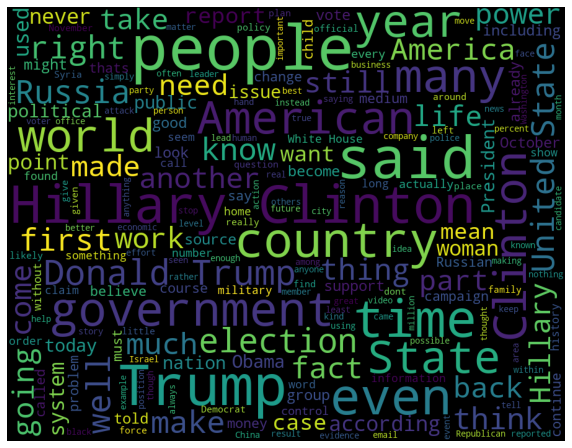

In [17]:
# Wordcloud for negative words
negative_words = " ".join([word for word in data["cleaned_text"][data["label"] == "FAKE"]])
wordcloud_neg = WordCloud(width=900, height=700, max_font_size=100, random_state=42).generate(negative_words)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.show()

## Name Entity Recognition

In [18]:
nlp = spacy.load("en_core_web_sm")

In [19]:
ners = []
for text in data["cleaned_text"].values:
  doc = nlp(text)

  for entity in doc.ents:
    ners.append((entity.text, entity.label_))

In [20]:
name_entity_df = pd.DataFrame(ners, columns = ["Entity Name", "Entity Label"])
sorted_entity = name_entity_df.groupby(by=["Entity Name", "Entity Label"]).size().sort_values(ascending=False).reset_index().rename(columns = {0: "Frequency"})

In [21]:
# Plot the first 50 entities
figure = px.bar(x=sorted_entity["Entity Name"][:50], y=sorted_entity["Frequency"][:50]) 
figure.show()

## Topic Modelling

> Topic Modelling is the task of extracting the main topics from the documents.

>For this task LDA is used. LDA is used to classify the text in a document to a particular topic

In [22]:
texts = data["cleaned_text"].apply(lambda x: x.split())
texts.head()

0    [Daniel, Greenfield, Shillman, Journalism, Fel...
1    [Google, Pinterest, Digg, Linkedin, Reddit, St...
2    [Secretary, State, John, Kerry, said, Monday, ...
3    [Kaydee, King, KaydeeKing, November, lesson, t...
4    [primary, York, frontrunners, Hillary, Clinton...
Name: cleaned_text, dtype: object

In [23]:
# Build the dictionary of words from the document
from gensim import corpora
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [24]:
# Build the LDA Model 
import gensim
topics = 10
lda = gensim.models.ldamodel.LdaModel(corpus, num_topics=topics, id2word=dictionary, passes=15)
lda.save("LDA_model.gensim")

In [25]:
display = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(display)

> The overlap of the clusters indicate that there is some similarity between them.

## Create Word2Vec Model

In [26]:
# Encode the target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data["Label"] = le.fit_transform(y=data["label"])

In [27]:
X = texts
y = data["Label"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [28]:
# Create word2vec model
size = 400
workers = 4
min_count = 5

tokens = pd.Series(texts).values
w2v_model = Word2Vec(sentences=tokens, size=size, workers=workers, min_count=min_count)
w2v_model.save("drive/MyDrive/ML Project/news/" + "word2vec" + str(size) + ".model")

In [29]:
# Word Embedding for the training data
# Save the word embedding of the training data in a csv file
w2v_train_file = "drive/MyDrive/ML Project/news" + "/train_w2v.csv"
i=0
with open(w2v_train_file, "w+") as w2v_file:
  for row in x_train:
    # Get the word Embedding for the given text and convert into list
    vec = (np.mean([w2v_model[word] for word in row if word in w2v_model.wv.vocab], axis=0)).tolist()
    
    # i = 0 implies that it is the start of the csv file so, we have to set the column name first 
    # The colums names are the number of dimensions of the word embedding
    if i == 0:
      header = ",".join(str(ele) for ele in range(size))
      w2v_file.write(header)
      w2v_file.write("\n")
    
    
    # If w2v model has word embedding for that sentence vec can't be null so, we join all the elements of the vec    
    if type(vec) is list:
      line = ",".join([str(element) for element in vec])
        
    #If w2v model does not have the word embedding for the given texts vec is null therefore, we have to append zeros for that sentence
    else:
      line = ",".join([str(0) for i in range(size)])
    
    w2v_file.write(line)
    w2v_file.write("\n")
    i += 1

In [30]:
# Word Embedding for test data
# Save the word embedding of the test data in csv file
w2v_test_file = "drive/MyDrive/ML Project/news" + "/test_w2v.csv"
i=0
with open(w2v_test_file, "w+") as w2v_file:
  for row in x_test:
    vec = (np.mean([w2v_model[word] for word in row if word in w2v_model.wv.vocab], axis=0)).tolist()
    
    if i == 0:
      header = ",".join(str(ele) for ele in range(size))
      w2v_file.write(header)
      w2v_file.write("\n")
    
    if type(vec) is list:
      line = ",".join([str(element) for element in vec])
    else:
      line = ",".join([str(0) for i in range(size)])
    
    w2v_file.write(line)
    w2v_file.write("\n")
    i += 1

In [31]:
# Import the training and testing files
train = pd.read_csv("drive/MyDrive/ML Project/news/train_w2v.csv")
test = pd.read_csv("drive/MyDrive/ML Project/news/test_w2v.csv")

## Building the Classifier

In [32]:
# Lightgbm Classifier
classifier = LGBMClassifier()
classifier.fit(train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [33]:
pred = classifier.predict(test)

## Evaluate model performance

In [34]:
# predict the values using cross validation
scores = cross_val_score(LGBMClassifier(), train, y_train, cv=5)
print(scores.mean())

0.8989756440436067


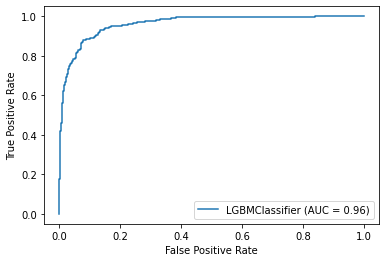

In [35]:
# Plot ROC curve
plot_roc_curve(classifier, test, y_test)

In [36]:
# Classification report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89       637
           1       0.88      0.91      0.89       630

    accuracy                           0.89      1267
   macro avg       0.89      0.89      0.89      1267
weighted avg       0.89      0.89      0.89      1267



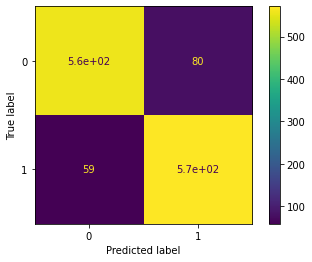

In [37]:
# Plot confusion matrix
plot_confusion_matrix(classifier, test, y_test);

In [38]:
# Calculate logloss
print(log_loss(y_test, pred))

3.7892295869668513


## Hyperparameter Tuning using Optuna




In [ ]:
def create_model(trial):
  # Set the parameter range
  num_leaves = trial.suggest_int('num_leaves', 10, 100)
  n_estimators = trial.suggest_int("n_estimators", 100, 3000)
  min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 5, 100)
  learning_rate = trial.suggest_uniform("learning_rate", 0.0001, 0.99)
  bagging_fraction = trial.suggest_uniform("bagging_fraction", 0.0001, 1)
  feature_fraction = trial.suggest_uniform("feature_fraction", 0.0001, 1)
  max_depth = trial.suggest_int("max_depth", 5, 20)

  model = LGBMClassifier(num_leaves=num_leaves,
                           n_estimators=n_estimators,
                           learning_rate=learning_rate,
                           bagging_fraction=bagging_fraction,
                           feature_fraction= feature_fraction,
                           min_data_in_leaf=min_data_in_leaf,
                           max_depth=max_depth)
  
  return model


def objective(trial):
  model = create_model(trial)
  model.fit(train, y_train)
  score = model.score(test, y_test)
  return score 

# Create study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

In [40]:
study.best_params

{'bagging_fraction': 0.7641097166459162,
 'feature_fraction': 0.4760403557587082,
 'learning_rate': 0.13662996697019486,
 'max_depth': 13,
 'min_data_in_leaf': 100,
 'n_estimators': 2052,
 'num_leaves': 70}

In [41]:
param = study.best_params

In [42]:
clf = LGBMClassifier(**param)
clf.fit(train, y_train)

LGBMClassifier(bagging_fraction=0.7641097166459162, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.4760403557587082, importance_type='split',
               learning_rate=0.13662996697019486, max_depth=13,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=100, min_split_gain=0.0, n_estimators=2052,
               n_jobs=-1, num_leaves=70, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [43]:
log_loss(y_test, clf.predict(test))

3.1894920388675794